<H1>Clustering</H1>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.metrics import silhouette_score, davies_bouldin_score, adjusted_rand_score, adjusted_mutual_info_score, homogeneity_score, calinski_harabasz_score, accuracy_score
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display, HTML, Markdown


from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs

from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import InterclusterDistance
from yellowbrick.cluster import KElbowVisualizer

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

<h3> Import and clean Data </h3>

<h1>Undersatnding Data </h1>
<ul>
<li>Age: age of the patient [years]</li>
<li>Sex: sex of the patient [M: Male, F: Female]</li>
<li>ChestPainType: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]</li>
<li>RestingBP: resting blood pressure [mm Hg]</li>
<li>Cholesterol: serum cholesterol [mm/dl]</li>
<li>FastingBS: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]</li>
<li>RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]</li>
<li>MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]</li>
<li>ExerciseAngina: exercise-induced angina [Y: Yes, N: No]</li>
<li>Oldpeak: oldpeak = ST [Numeric value measured in depression]</li>
<li>ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]</li>
<li>HeartDisease: output class [1: heart disease, 0: Normal]</li>
    </ul>

In [2]:
#Heart Data
data = pd.read_csv('../data/heartFailurePrediction/heart.csv', sep=',')

#handling cholestrol 0
data['Cholesterol'] = data['Cholesterol'].replace(0, data['Cholesterol'].mean())

#scale data
# Select numerical variables
data_X = data.drop("HeartDisease", axis=1)
# data_X = data_X.drop("Id", axis=1)
numeric = data_X.select_dtypes(exclude=object).columns
nonnumeric = data_X.select_dtypes(include=object).columns
#numeric.remove('quality')
print(type(numeric))
for col in numeric:
    data_X[col] = StandardScaler().fit_transform(data_X[[col]])

data = data_X.join(data['HeartDisease'])

# Dealing with the outliers (RestingBP)
q1 = data['RestingBP'].quantile(0.25)
q3 = data['RestingBP'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr

# Median imputation (RestingBP)
med = np.median(data['RestingBP'])
for i in data['RestingBP']:
    if i > Upper_tail or i < Lower_tail:
            data['RestingBP'] = data['RestingBP'].replace(i, med)

# Dealing with outliers (Cholesterol)
q1 = data['Cholesterol'].quantile(0.25)
q3 = data['Cholesterol'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr

# Median imputation (Cholesterol) just on upper tail
med = np.median(data['Cholesterol'])
for i in data['Cholesterol']:
    if i > Upper_tail:
        data['Cholesterol'] = data['Cholesterol'].replace(i, med)

# Select numerical variables
objList = data.select_dtypes(include=object).columns

le = LabelEncoder()
for feat in objList:
    data[feat] = le.fit_transform(data[feat].astype(str))
    

# # #one-hot-encoder

# data_H = pd.get_dummies(data, columns = ['Sex','ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope'])
    
#below vars are used.
data_H = data
heartX=data_H.drop("HeartDisease", 1).copy().values
hearty=data_H[["HeartDisease"]]

<class 'pandas.core.indexes.base.Index'>


In [3]:
data_H.head(5)

Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  \
0 -1.433140    1              1   0.410909     0.942044  -0.551341   
1 -0.478484    0              2   1.491752    -0.997102  -0.551341   
2 -1.751359    1              1  -0.129513     0.835302  -0.551341   
3 -0.584556    0              0   0.302825    -0.392231  -0.551341   
4  0.051881    1              2   0.951331    -0.730247  -0.551341   

   RestingECG     MaxHR  ExerciseAngina   Oldpeak  ST_Slope  HeartDisease  
0           1  1.382928               0 -0.832432         2             0  
1           1  0.754157               0  0.105664         1             1  
2           2 -1.525138               0 -0.832432         2             0  
3           1 -1.132156               1  0.574711         1             1  
4           1 -0.581981               0 -0.832432         2             0

In [4]:
data_H.shape

(918, 12)

<h1>Undersatnding Data </h1>
<ul>
    <li>1 - fixed acidity</li>
    <li>2 - volatile acidity</li>
    <li>3 - citric acid</li>
    <li>4 - residual sugar</li>
    <li>5 - chlorides</li>
    <li>6 - free sulfur dioxide</li>
    <li>7 - total sulfur dioxide</li>
    <li>8 - density</li>
    <li>9 - pH</li>
    <li>10 - sulphates</li>
    <li>11 - alcohol</li>
    <li>12 - quality (score between 0 and 10, updated to binary)</li>
    </ul>

In [5]:
#Wine Data
data = pd.read_csv('../data/wineQualityDataset/WineQT.csv', sep=',')
#Drop id
data = data.drop("Id", axis=1)
#drop duplicate
data = data.drop_duplicates().reset_index(drop=True)

#commented
data = data.drop(data[data.quality == 3].index).reset_index(drop=True)
data = data.drop(data[data.quality == 4].index).reset_index(drop=True)
data.loc[data["quality"] == 8, "quality"] = 7

#normalize the data
# Select numerical variables
data_X = data.drop("quality", axis=1)
# data_X = data_X.drop("Id", axis=1)
numeric = data_X.select_dtypes(exclude=object).columns
#numeric.remove('quality')
print(type(numeric))
for col in numeric:
    data_X[col] = StandardScaler().fit_transform(data_X[[col]])

data = data_X.join(data['quality'])

#update y values
data.loc[data["quality"] == 5, "quality"] = 0
data.loc[data["quality"] == 6, "quality"] = 1
data.loc[data["quality"] == 7, "quality"] = 2

#below vars are used.
data_W = data
wineX=data_W.drop("quality", 1).copy().values
winey= data_W[["quality"]]

<class 'pandas.core.indexes.base.Index'>


In [6]:
data_W.head(5)

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.519338          0.992767    -1.403588       -0.471886  -0.234354   
1      -0.289461          2.017997    -1.403588        0.059078   0.242187   
2      -0.289461          1.334510    -1.197651       -0.168478   0.112221   
3       1.664501         -1.399438     1.479526       -0.471886  -0.256015   
4      -0.519338          0.764938    -1.403588       -0.547738  -0.256015   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0            -0.463861             -0.380205  0.575815  1.299106  -0.605634   
1             0.911515              0.611462  0.054935 -0.699605   0.135125   
2            -0.070896              0.220805  0.159111 -0.312758  -0.050065   
3             0.125586              0.401109  0.679992 -0.957503  -0.482174   
4            -0.267378             -0.199902  0.575815  1.299106  -0.605634   

    alcohol  quality  
0 -0.969962        0  
1 -0.605173        0  
2 -0.605173        0  
3 -0.605173        1  
4 -0.969962        0

In [7]:
data_W.shape


(979, 12)

In [8]:
# stratified sampling Heart Disease
from sklearn.model_selection import StratifiedShuffleSplit

print("Splitting StratifiedShuffleSplit into train/test")

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.3, random_state=15)
for train_ind, test_ind in split.split(data_H, data_H["HeartDisease"]):
    train_set = data_H.loc[train_ind]
    test_set = data_H.loc[test_ind]

yH_train = train_set[["HeartDisease"]]
XH_train = train_set.drop("HeartDisease", axis=1)
yH_test = test_set[["HeartDisease"]]
XH_test = test_set.drop("HeartDisease", axis=1)

split = StratifiedShuffleSplit(n_splits=1 , test_size=0.3, random_state=15)
for train_ind, test_ind in split.split(data_W, data_W["quality"]):
    train_set = data_W.loc[train_ind]
    test_set = data_W.loc[test_ind]

yW_train = train_set[["quality"]]
XW_train = train_set.drop("quality", axis=1)
yW_test = test_set[["quality"]]
XW_test = test_set.drop("quality", axis=1)


Splitting StratifiedShuffleSplit into train/test


[]

<Figure size 1080x720 with 0 Axes>

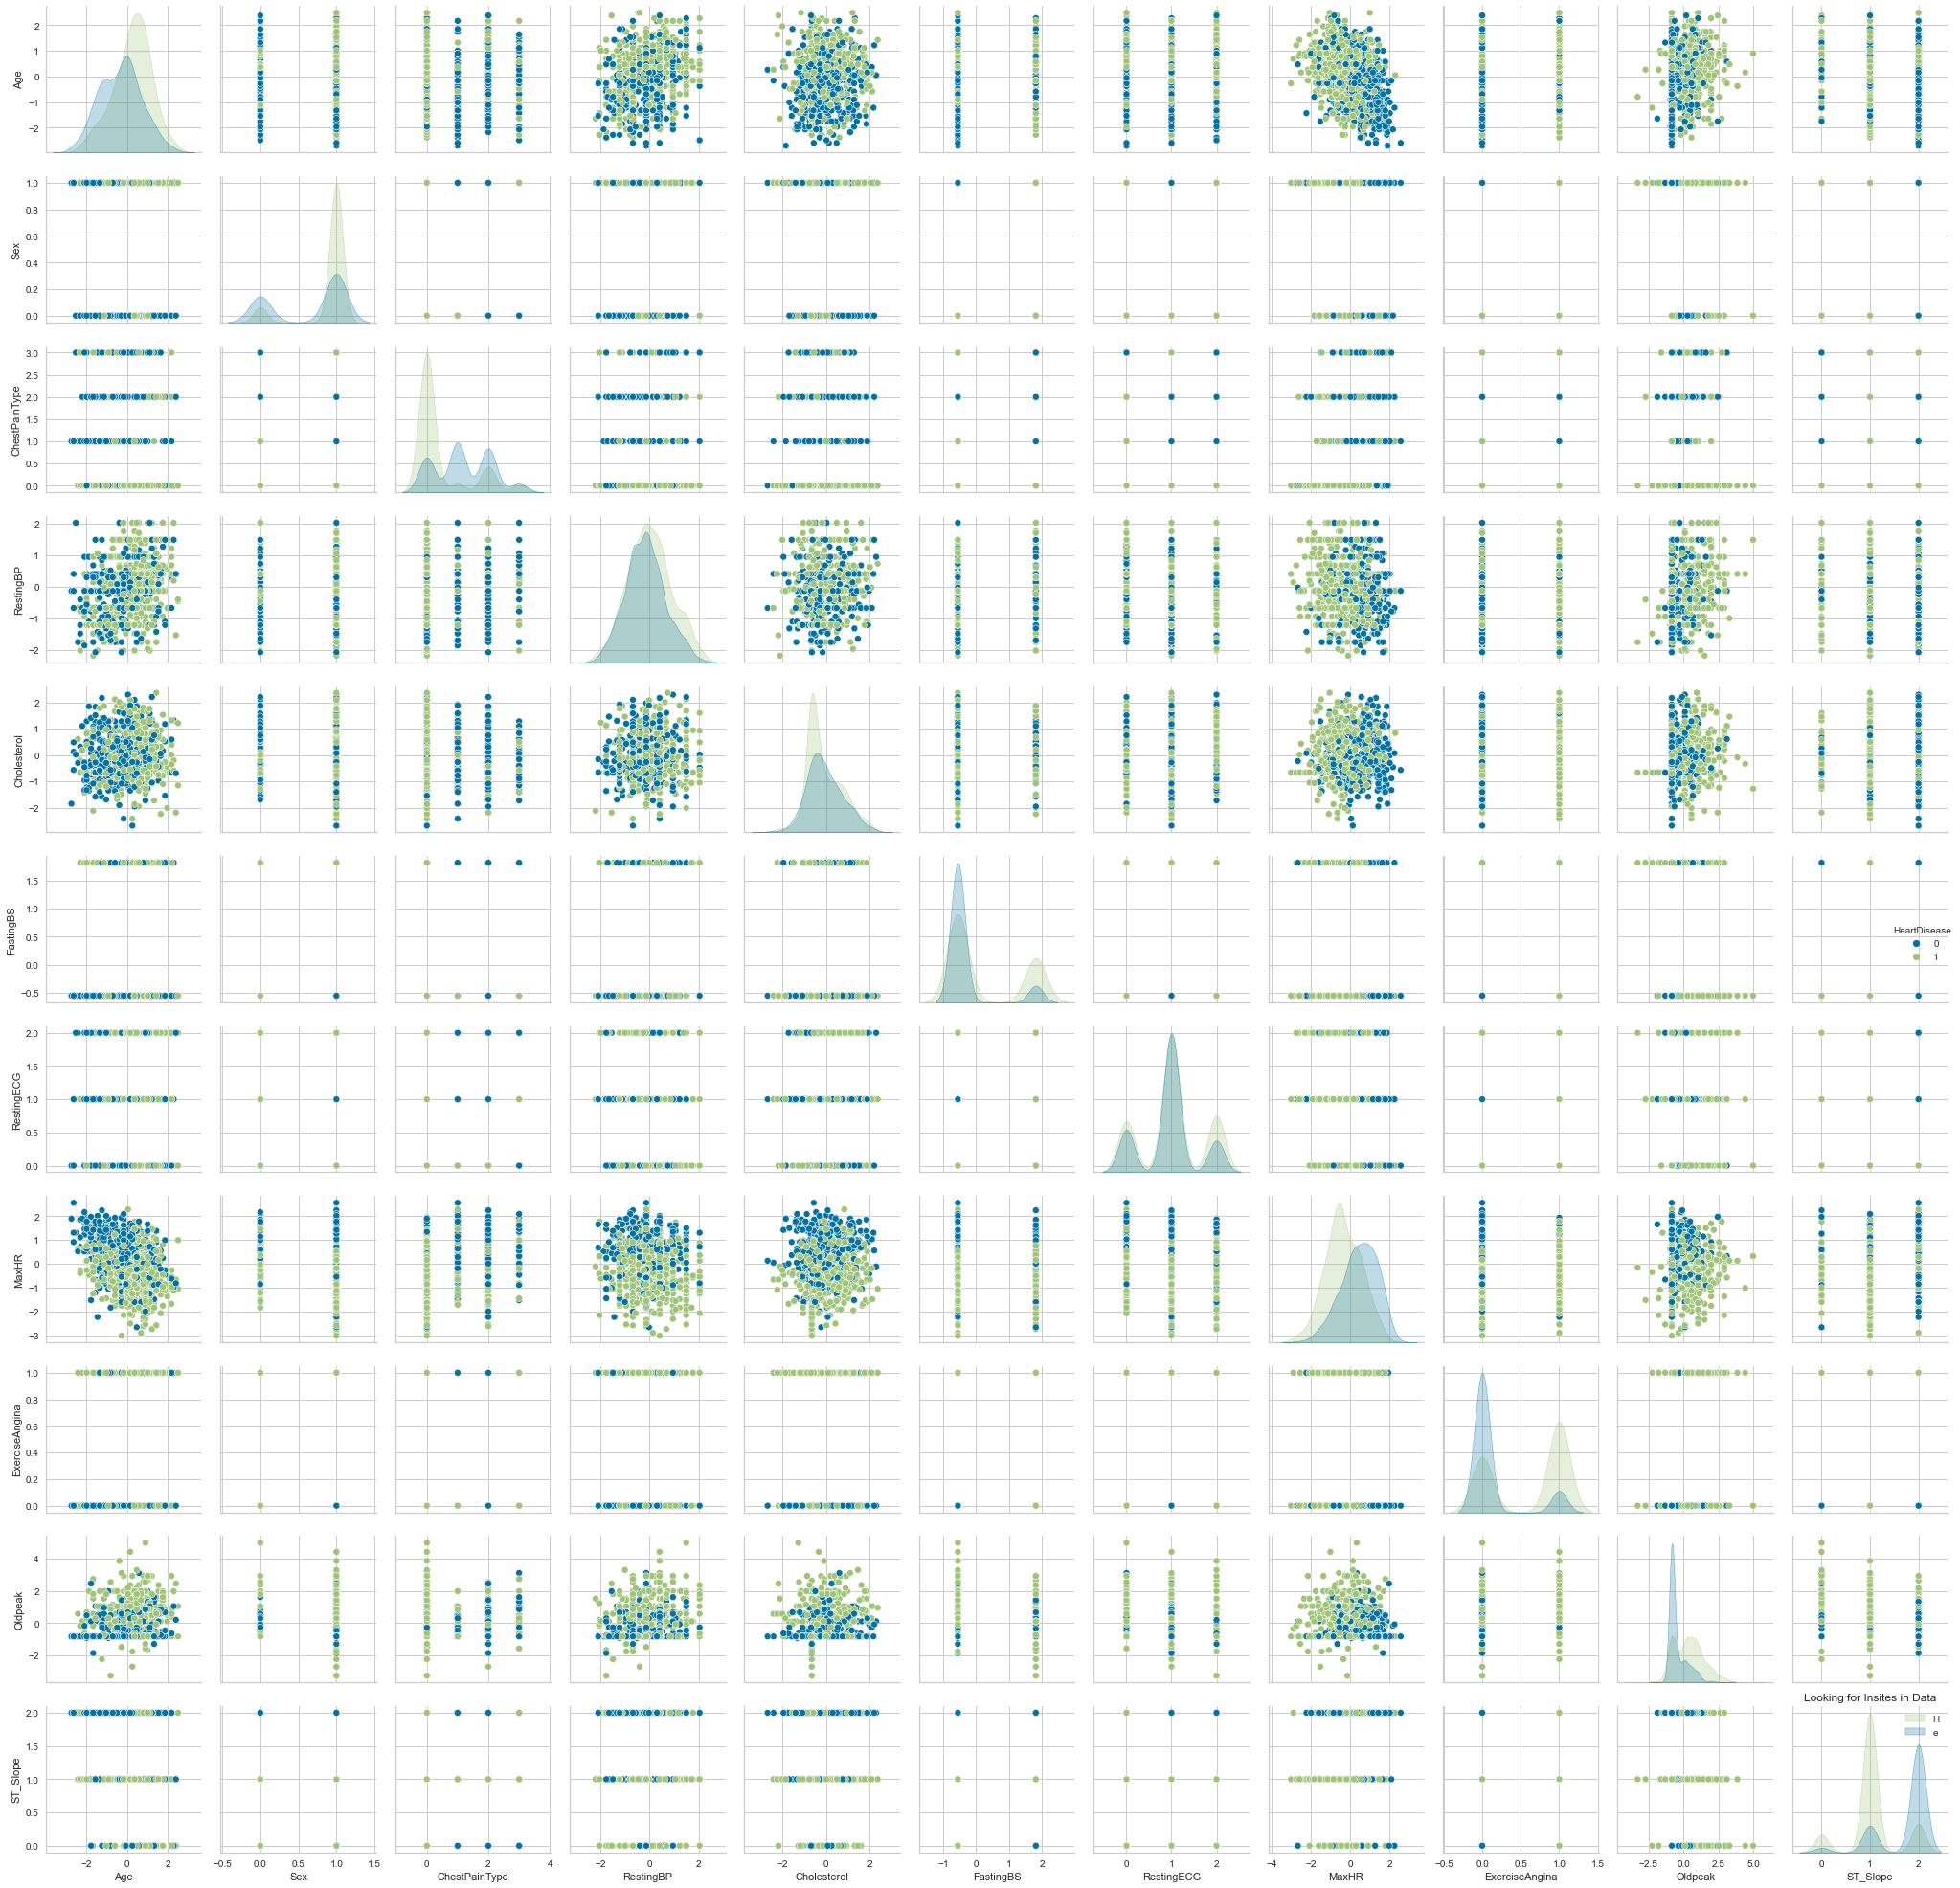

In [9]:
plt.figure(figsize=(15,10))
sns.pairplot(data_H,hue="HeartDisease")
plt.title("Looking for Insites in Data")
plt.legend("HeartDisease")
plt.tight_layout()
plt.plot()

[]

<Figure size 1080x720 with 0 Axes>

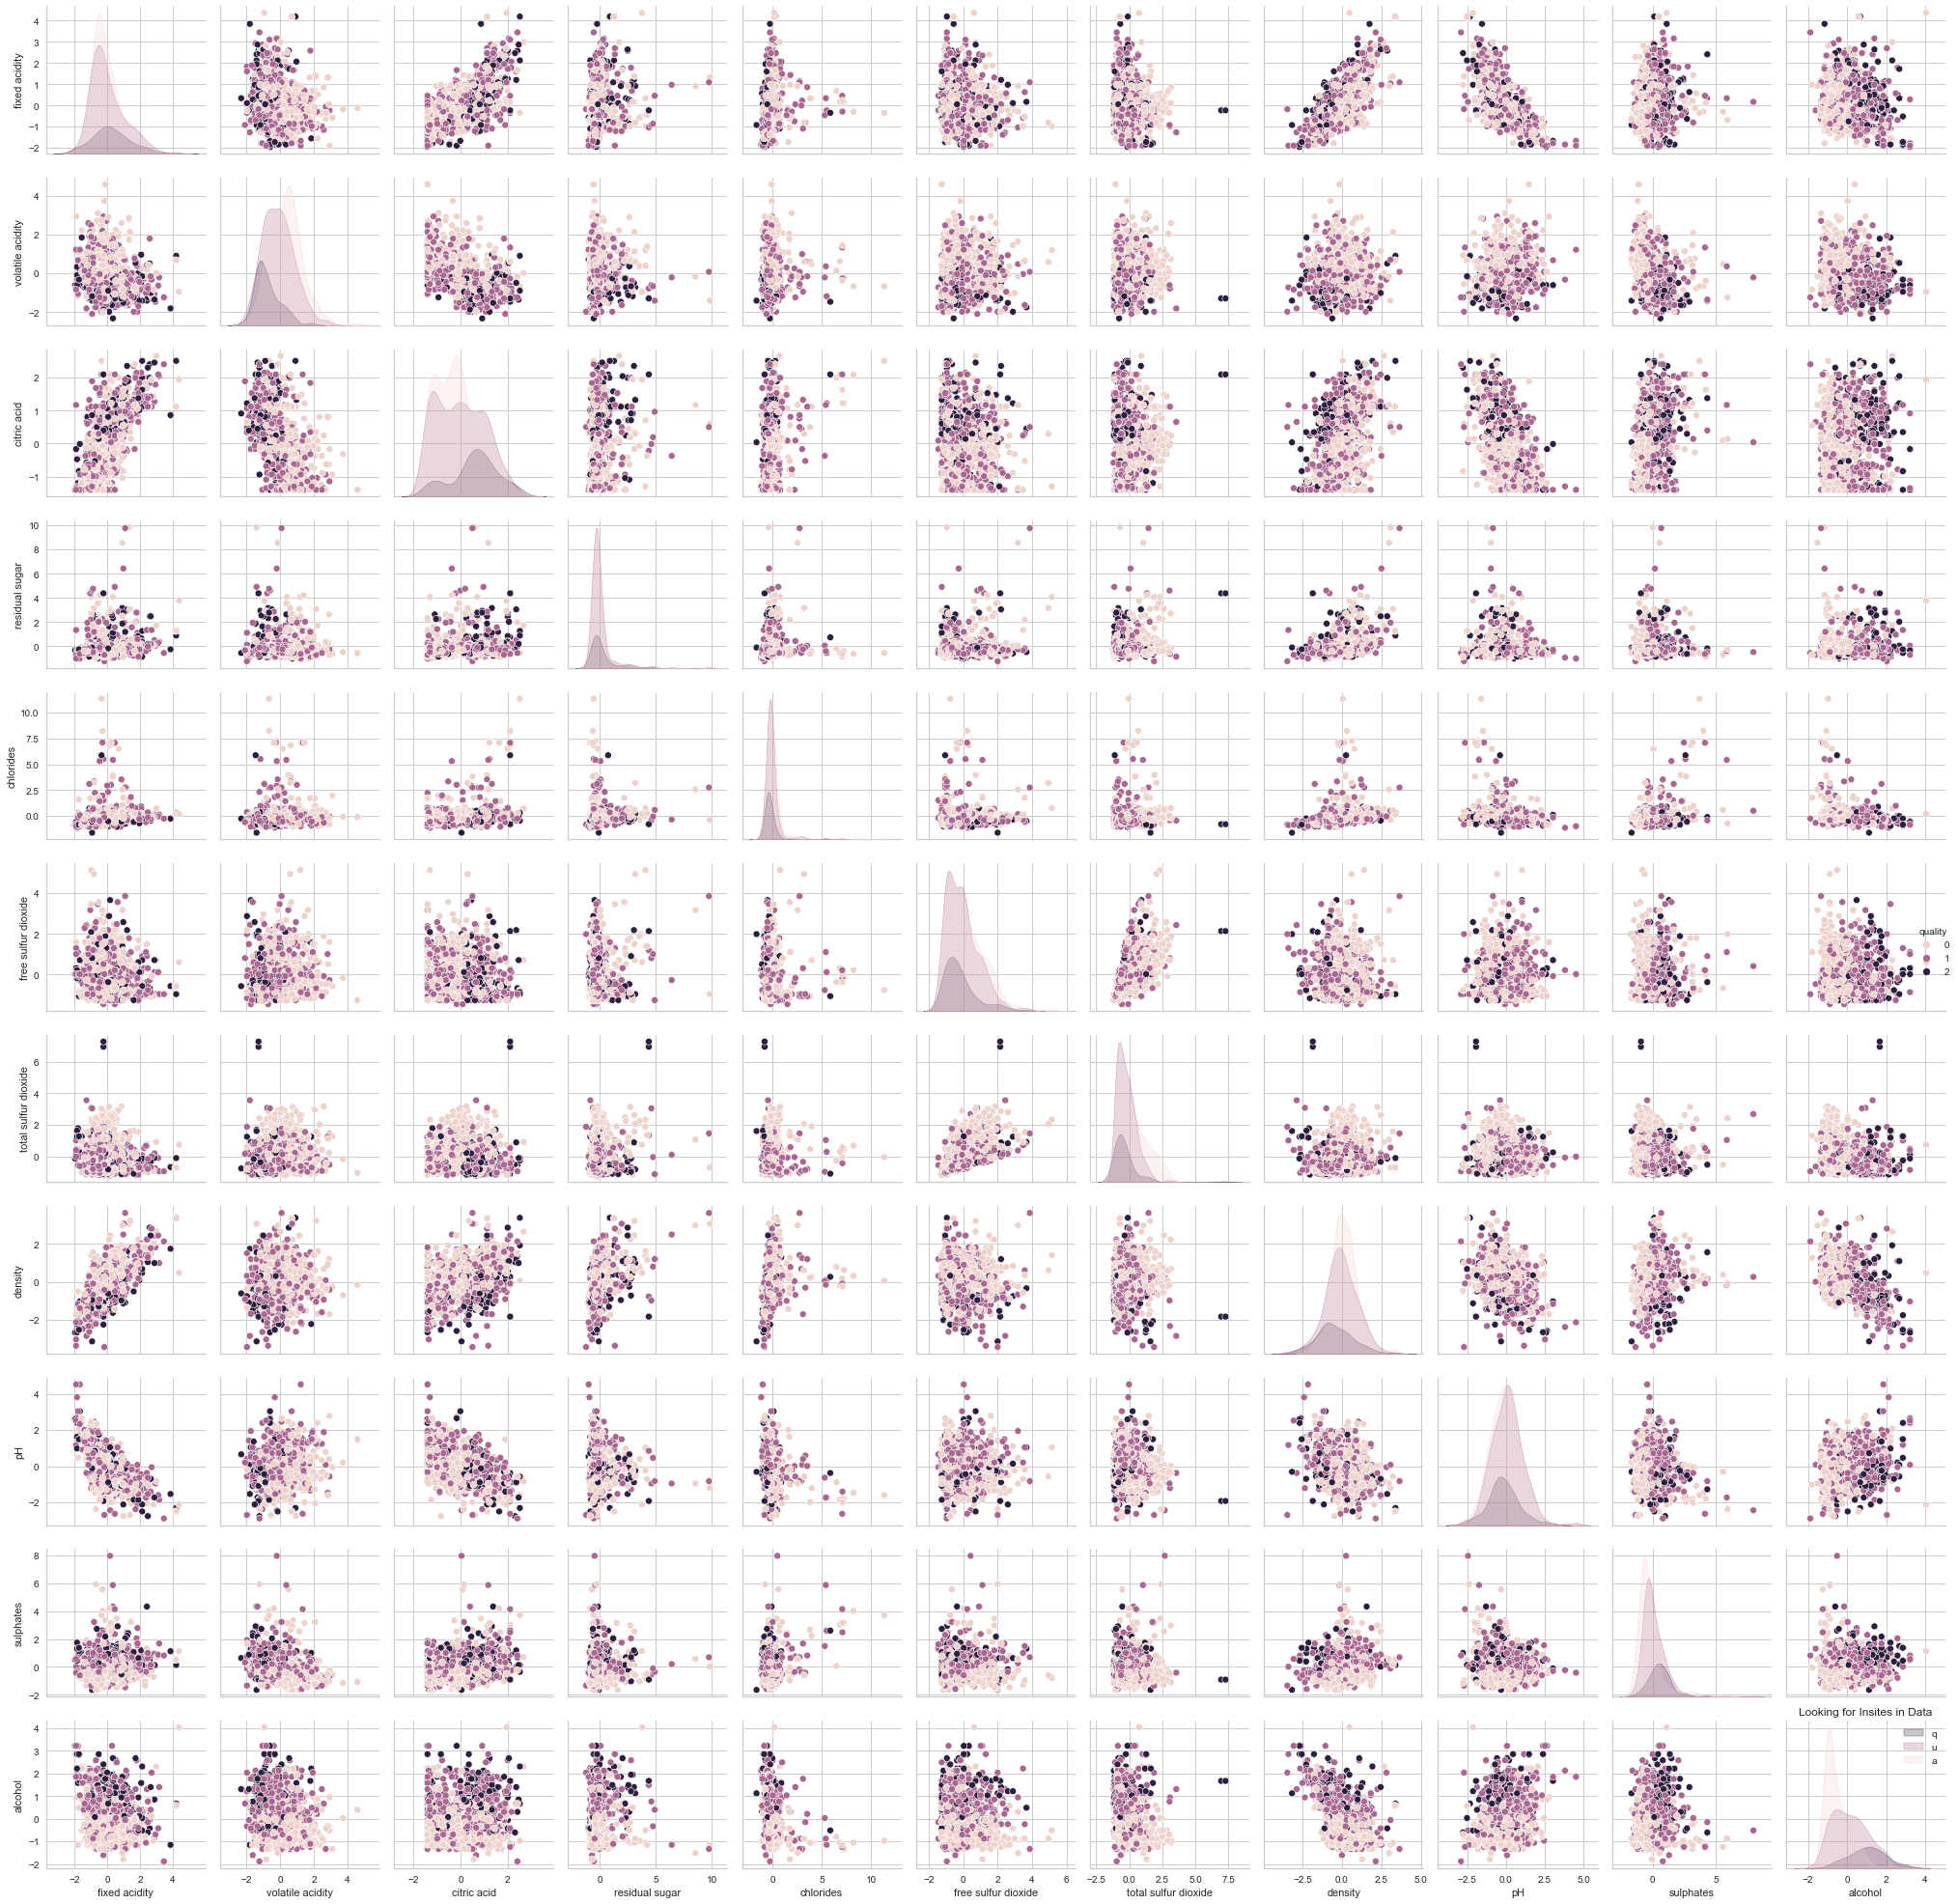

In [10]:
plt.figure(figsize=(15,10))
sns.pairplot(data_W,hue="quality")
plt.title("Looking for Insites in Data")
plt.legend("quality")
plt.tight_layout()
plt.plot()

<h3>Helper Methods</h3>

In [10]:
# elbow method and silhouette score (kmeans plot showing)
def kmeans_k_selection_plots(title, data):
    inertia = []
    s_scores = []
    db_scores = []
    ch_score = []
    clusters = range(2,16)
    for i in clusters:
        kmeans = KMeans(n_clusters=i,init='k-means++', random_state=42)
        kmeans.fit(data)
        inertia.append(kmeans.inertia_)
        
        k_y = kmeans.predict(data)
        s_scores.append(silhouette_score(data, k_y))
        db_scores.append(davies_bouldin_score(data, k_y))
        ch_score.append(calinski_harabasz_score(data, k_y))
                
            
    # Plot the data
    _, axes = plt.subplots(1, 4, figsize=(28, 7))
    
    axes[0].set_title(title + " - K-mean Inertia")
    axes[0].set_xlabel("Clusters")
    axes[0].set_ylabel("K-mean Inertia")
    axes[0].set_xticks(clusters)
    axes[0].grid()
    axes[0].plot(clusters, inertia, '-o')
    
    axes[1].set_title(title + " - Silhouette Score")
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("Silhouette Score")
    axes[1].set_xticks(clusters)
    axes[1].grid()
    axes[1].plot(clusters, s_scores, '-o')
   
    axes[2].set_title(title + " - Davies Bouldin Score")
    axes[2].set_xlabel("Clusters")
    axes[2].set_ylabel("Davies Bouldin Score")
    axes[2].set_xticks(clusters)
    axes[2].grid()
    axes[2].plot(clusters, db_scores, '-o')

    axes[3].set_title(title + " - CH Score")
    axes[3].set_xlabel("Clusters")
    axes[3].set_ylabel("calinski_harabasz_score score")
    axes[3].set_xticks(clusters)
    axes[3].grid()
    axes[3].plot(clusters, ch_score, '-o')

    plt.show()



In [11]:
# aic, bic and silhouette plots (expectation maximization)
def em_k_selection_plot(title, data):
    aic = []
    bic = []
    s_scores = []
    log_likelihood = []
    clusters = range(2,15)
    for i in clusters:
        
        gmm = GaussianMixture(n_components=i, random_state=42)
        gmm.fit(data)
        
        gmm_labels = gmm.predict(data)

        s_scores.append(silhouette_score(data, gmm_labels))
        aic.append(gmm.aic(data))
        bic.append(gmm.bic(data))
        log_likelihood.append(gmm.score(data))
                
    # Plot the data
    _, axes = plt.subplots(1, 4, figsize=(28, 7))
    
    axes[0].set_title(title + " - AIC Score")
    axes[0].set_xlabel("Clusters")
    axes[0].set_ylabel("AIC Score")
    axes[0].set_xticks(clusters)
    axes[0].grid()
    axes[0].plot(clusters, aic, '-o')
    
    axes[1].set_title(title + " - BIC Score")
    axes[1].set_xlabel("Clusters")
    axes[1].set_ylabel("BIC Score")
    axes[1].set_xticks(clusters)
    axes[1].grid()
    axes[1].plot(clusters, bic, '-o')
   
    axes[2].set_title(title + " - LL Score")
    axes[2].set_xlabel("Clusters")
    axes[2].set_ylabel("Log Likelihood score")
    axes[2].set_xticks(clusters)
    axes[2].grid()
    axes[2].plot(clusters, log_likelihood, '-o')
    
    axes[3].set_title(title + " - Silhouette Score")
    axes[3].set_xlabel("Clusters")
    axes[3].set_ylabel("Silhouette Score")
    axes[3].set_xticks(clusters)
    axes[3].grid()
    axes[3].plot(clusters, s_scores, '-o')

    plt.show()
    
def em_k_selection_plot_2(title, data):    
    n_components = np.arange(1, 21)
    models = [GaussianMixture(n, covariance_type='full', random_state=42).fit(data)
              for n in n_components]

    plt.plot(n_components, [m.bic(data) for m in models], label='BIC')
    plt.plot(n_components, [m.aic(data) for m in models], label='AIC')
    plt.title(title + " - AIC-BIC together", fontsize=20)
    plt.legend(loc='best')
    plt.xlabel('n_components')
    plt.show()

In [12]:
from sklearn.cluster import MeanShift, estimate_bandwidth

# using MeanShift to get an estimate
def meanshift_cluster(title, data):
    bandwidth = estimate_bandwidth(data, 
                               quantile=0.3, 
                               n_jobs=-1)
    ms = MeanShift(bandwidth=bandwidth, 
               bin_seeding=False, 
               n_jobs=-1, 
               max_iter=500)
    ms.fit(data)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_
    labels_unique = np.unique(labels)
    n_clusters_ = len(labels_unique)
    print(f"Number of estimated clusters for {title}: {n_clusters_}")
    

In [13]:
#https://towardsdatascience.com/selecting-optimal-k-for-k-means-clustering-c7579fd2e926
def model_report_multiclass(model,
                            X_train,
                            y_train,
                            X_test,
                            y_test,
                            show_train_report=True,
                            show_test_report=True,
                            fitted_model=False,
                            cmap=['cool', 'copper_r'],
                            normalize='true',
                            figsize=(15, 5)):
    """
    Dispalys model report of multiclass classification model.
    Report of model performance using train-test split dataset.
    Shows train and test score, Confusion Matrix and, ROC Curve of performane of test data. 
    Uses sklearn and yellowbrick for plotting.
    
    Parameters:
    -----------
    model : object, scikit-learn model object; no default.
    X_train : pandas.DataFrame, predictor variable training data split; no default,
    y_train : pandas.DataFrame, target variable training data split; no default,
    X_test : pandas.DataFrame, predictor variable test data split; no default,
    y_test : pandas.DataFrame, target variable test data split; no default,
    cmap : {NOT IMPLIMENTED} list of str, colormap of Confusion Matrix; default: ['cool', 'copper_r'],
        cmap of train and test data
    normalize : {NOT IMPLIMENTED} str, normalize count of Confusion Matrix; default: 'true',
        - `true` to normalize counts.
        - `false` to show raw counts.
    figsize : tuple ``(lenght, height) in inchs``, figsize of output; default: (16, 6),
    show_train_report : boolean; default: False,
        - True, to show report.
        - False, to turn off report.
    fitted_model : bool; default: False,
        - if True, fits model to train data and generates report.
        - if False, does not fits model and generates report.
        Use False for previously fitted model.
    ---version 0.9.14---
    """
    if fitted_model is False:
        model.fit(X_train, y_train)
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)

    def str_model_(model):
        """Helper function to get model class display statement, this text conversion breaks code if 
        performed in ``model_report`` function's local space. This function is to isolate from the 
        previous function's local space."""
        str_model = str(model.__class__).split('.')[-1][:-2]
        display(
            HTML(
                f"""<strong>Report of {str_model} type model using train-test split dataset.</strong>"""
            ))

    str_model_(model)
    print(f"{'*'*90}")
    print(f"""Train accuracy score: {train.round(4)}""")
    print(f"""Test accuracy score: {test.round(4)}""")
    if abs(train - test) <= .05:
        print(
            f"    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold."
        )
    elif (train - test) > .05:
        print(
            f"    Possible Overfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    elif (train - test) < -.05:
        print(
            f"    Possible Underfitting, diffrence of scores {round(abs(train-test)*100,2)}% crossed 5% thresh hold."
        )
    print(f"{'*'*90}")
    print("")

    
    
def get_Dumy_classifierReport(cluster_df):
    X_feat_imp = cluster_df.drop(columns='Clusters').copy()
    y_feat_imp = cluster_df.Clusters.copy()
    X_feat_imp_train, X_feat_imp_test, y_feat_imp_train, y_feat_imp_test = train_test_split(
        X_feat_imp, y_feat_imp, train_size=.8)
    # Random Forest
    clf_rf = RandomForestClassifier(
        n_jobs=-1,
        criterion='entropy',
        min_samples_leaf=5,
        min_samples_split=6,
        class_weight='balanced_subsample',
    )
    model_report_multiclass(clf_rf,
                           X_feat_imp_train,
                           y_feat_imp_train,
                           X_feat_imp_test,
                           y_feat_imp_test,
                           show_train_report=True)

In [14]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

def generate_kmeans_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[15, 40])
    col_ = 0
    for i in k:
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        kmeans = KMeans(n_clusters=i, algorithm="full")
        visualizer = InterclusterDistance(kmeans, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    


def generate_EM_SV_ICD_plots(X, k):
    plot_nums = len(k)
    fig, axes = plt.subplots(plot_nums, 2, figsize=[25, 40])
    col_ = 0
    for i in k:
        GMM = GaussianMixture(n_components=i,n_init=2,
                              tol=1e-3,
                              max_iter=1000)
        visualizer = SilhouetteVisualizer(GaussianMixture, colors='yellowbrick', ax=axes[col_][0])
        visualizer.fit(X)
        visualizer.finalize()
        
        GMM = GaussianMixture(n_components=i,n_init=2,
                              tol=1e-3,
                              max_iter=1000)
        visualizer = InterclusterDistance(GMM, ax=axes[col_][1])
        visualizer.fit(X)
        visualizer.finalize()
        
        col_+=1
    plt.show()
    
def generate_distance_bw_gmms_plots(X, n):
    # https://towardsdatascience.com/gaussian-mixture-model-clusterization-how-to-select-the-number-of-components-clusters-553bef45f6e4
    
    n_clusters=np.arange(2, n)
    iterations=n
    results=[]
    res_sigs=[]
    for n in n_clusters:
        dist=[]

        for iteration in range(iterations):
            train, test=train_test_split(X, test_size=0.5)

            gmm_train=GaussianMixture(n, n_init=2).fit(train) 
            gmm_test=GaussianMixture(n, n_init=2).fit(test) 
            dist.append(gmm_js(gmm_train, gmm_test))
        selec=SelBest(np.array(dist), int(iterations/5))
        result=np.mean(selec)
        res_sig=np.std(selec)
        results.append(result)
        res_sigs.append(res_sig)


    plt.errorbar(n_clusters, results, yerr=res_sigs)
    plt.title("Distance between Train and Test GMMs", fontsize=20)
    plt.xticks(n_clusters)
    plt.xlabel("N. of components")
    plt.ylabel("Distance")
    plt.show()
    


In [15]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

def Tsne_plot(X,y,p):
# We want to get TSNE embedding with 2 dimensions
    n_components = 2
    tsne = TSNE(n_components, random_state=33, perplexity=p)
    tsne_result = tsne.fit_transform(X)
    tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
    tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
    fig, ax = plt.subplots(1)
    sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
    lim = (tsne_result.min()-5, tsne_result.max()+5)
    ax.set_xlim(lim)
    ax.set_ylim(lim)
    ax.set_aspect('equal')
    ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

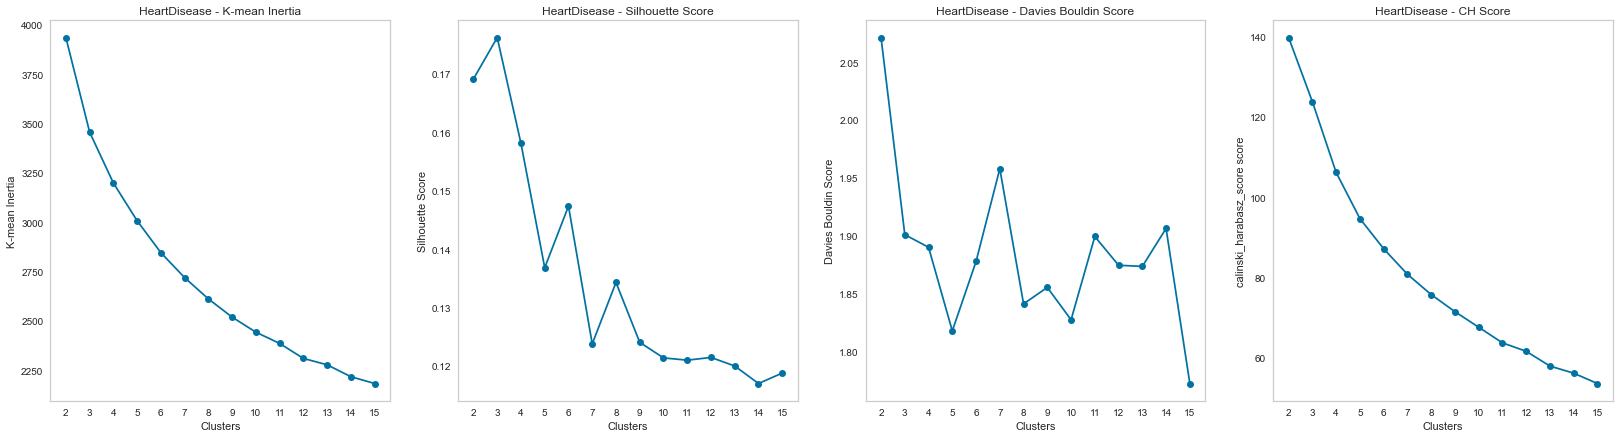

In [17]:
kmeans_k_selection_plots('HeartDisease', XH_train)

In [18]:
meanshift_cluster('HeartDisease', XH_train)

Number of estimated clusters for HeartDisease: 1


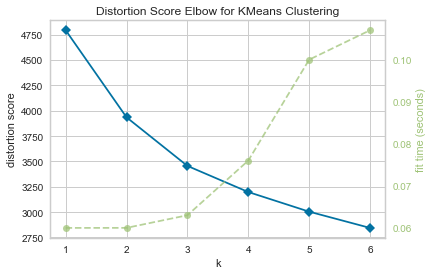

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [19]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,7))

visualizer.fit(XH_train)        # Fit the data to the visualizer
visualizer.show()  

<Figure size 1080x432 with 0 Axes>

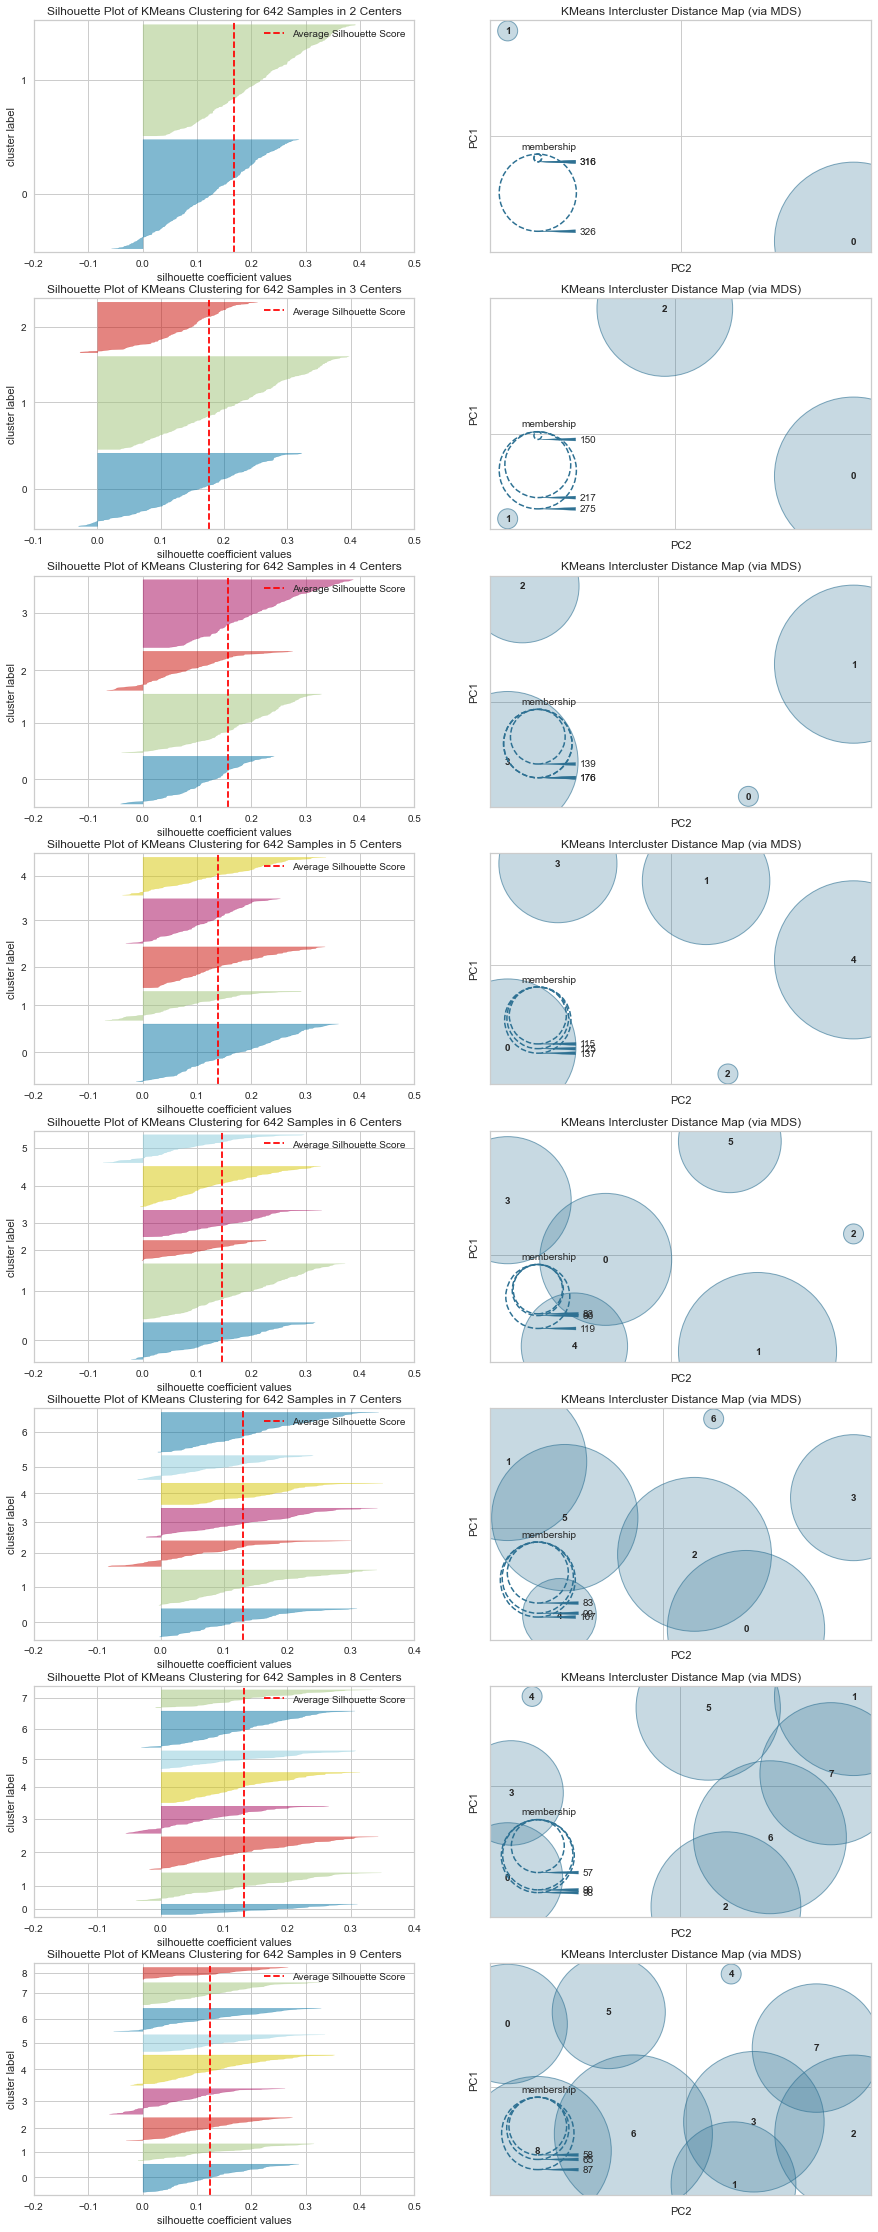

In [20]:
k = list(range(2,10))
plt.figure(figsize=(15,6))
generate_kmeans_SV_ICD_plots(XH_train, k)

<p> Clear k = 3 for SS, 5 for DB and inertia, but 2 is good</p>

In [19]:
# Kmeans HeartDataset
# setting number of cluster to 5. overfits and 3 works
n_clusters=4
kmeans = KMeans(
    init='k-means++',
    algorithm='auto',
    n_clusters=n_clusters,
    max_iter=1000,
    random_state=1,  # selecting random_state=1 for reproducibility
    verbose=0).fit(XH_train)

# using prediction to create a dataframe
clusters = kmeans.predict(XH_train)
cluster_df = XH_train.copy()
cluster_df['Clusters'] = clusters
cluster_df

# distribution of classes (%)
(cluster_df.Clusters.value_counts(1)*100).round(2)

2    31.78
1    27.41
0    22.43
3    18.38
Name: Clusters, dtype: float64

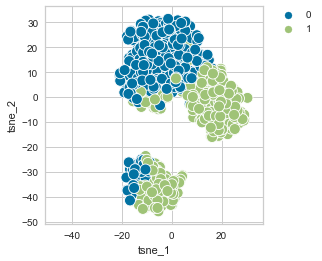

In [22]:
Tsne_plot(XH_train,clusters,30)

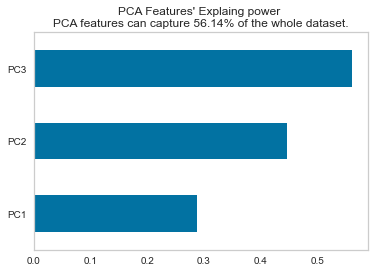

In [20]:

pca = PCA(n_components=3)
pc_feature_names = [f"PC{x}" for x in range(1, pca.n_components + 1)]
pca_data = pca.fit_transform(cluster_df)
pca_df = pd.DataFrame(pca_data, columns=pc_feature_names)
pd.Series(pca.explained_variance_ratio_.cumsum(), index=pc_feature_names).plot(
    kind='barh',
    title=
    f"""PCA Features' Explaing power \nPCA features can capture {((pca.explained_variance_ratio_.cumsum()[-1])*100).round(2)}% of the whole dataset."""
)
plt.grid()
plt.show()

pca_df['Clusters'] = clusters.astype('str')
fig = px.scatter_3d(pca_df,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color='Clusters',
                    title='Cluster visualization with the help of PCA',
                    template='plotly_dark')
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()


In [24]:
get_Dumy_classifierReport(cluster_df)

******************************************************************************************
Train accuracy score: 0.9805
Test accuracy score: 0.9302
    Possible Overfitting, diffrence of scores 5.03% crossed 5% thresh hold.
******************************************************************************************



In [25]:
# Kmeans HeartDataset
km_3 = KMeans(n_clusters=2,
                    init="k-means++",
                    random_state=42).fit(XH_train)

km_3_pred = km_3.predict(XH_train)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_3_pred, yH_train.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_3_pred, yH_train.values.ravel()))
print("accuracy Score:       ", accuracy_score(km_3_pred, yH_train.values.ravel()))
print("adjusted_mutual_info Score:       ", adjusted_mutual_info_score(km_3_pred, yH_train.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(XH_train, km_3_pred))

Adjusted Rand Score:      0.3275303464766054
Homogeneity Score:        0.257429782931065
accuracy Score:        0.21339563862928349
adjusted_mutual_info Score:        0.25762998877070437
Calinski Harabasz Score:  139.72218569744263


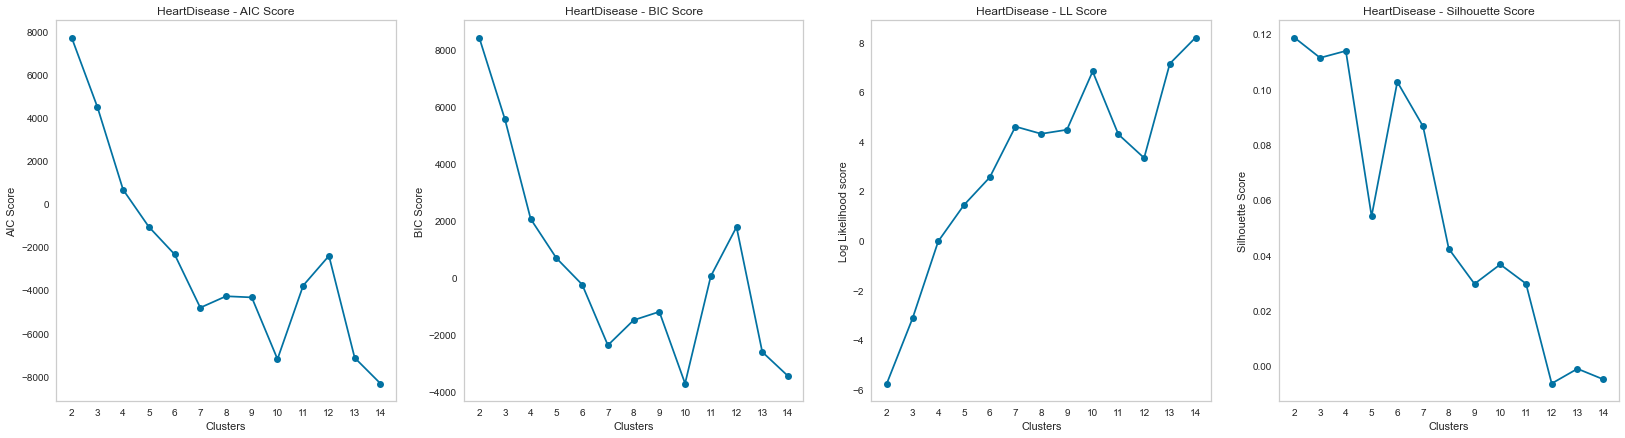

In [26]:
em_k_selection_plot('HeartDisease', XH_train)

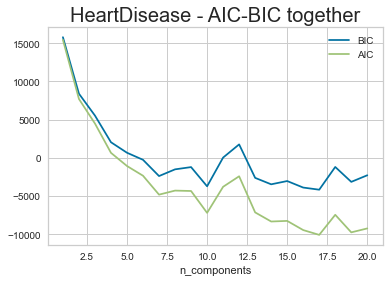

In [68]:
em_k_selection_plot_2('HeartDisease', XH_train)

<p> Clear k = 3</p>

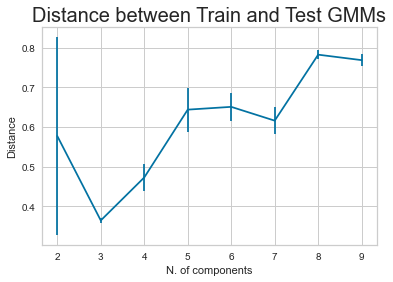

In [47]:
generate_distance_bw_gmms_plots(XH_train, 10)

In [77]:
# EM HeartDataset
# setting number of cluster to 5. overfits and 3 works
n_c=3
gmm_h_pred = GaussianMixture(n_components=n_c,
                              n_init=2,
                              tol=1e-3,
                              max_iter=1000, random_state=42).fit(XH_train)
clusters = gmm_h_pred.predict(XH_train)

cluster_df = XH_train.copy()
cluster_df['Clusters'] = clusters
cluster_df

# distribution of classes (%)
(cluster_df.Clusters.value_counts(1)*100).round(2)

1    46.57
0    29.75
2    23.68
Name: Clusters, dtype: float64

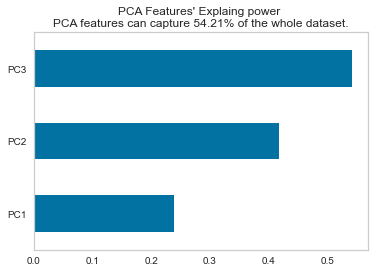

In [78]:
pca = PCA(n_components=3)
pc_feature_names = [f"PC{x}" for x in range(1, pca.n_components + 1)]
pca_data = pca.fit_transform(cluster_df)
pca_df = pd.DataFrame(pca_data, columns=pc_feature_names)
pd.Series(pca.explained_variance_ratio_.cumsum(), index=pc_feature_names).plot(
    kind='barh',
    title=
    f"""PCA Features' Explaing power \nPCA features can capture {((pca.explained_variance_ratio_.cumsum()[-1])*100).round(2)}% of the whole dataset."""
)
plt.grid()
plt.show()

pca_df['Clusters'] = clusters.astype('str')
fig = px.scatter_3d(pca_df,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color='Clusters',
                    title='Cluster visualization with the help of PCA',
                    template='plotly_dark')
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()

In [79]:
get_Dumy_classifierReport(cluster_df)

******************************************************************************************
Train accuracy score: 1.0
Test accuracy score: 1.0
    No over or underfitting detected, diffrence of scores did not cross 5% thresh hold.
******************************************************************************************



<h2>Wine Quality</h2>

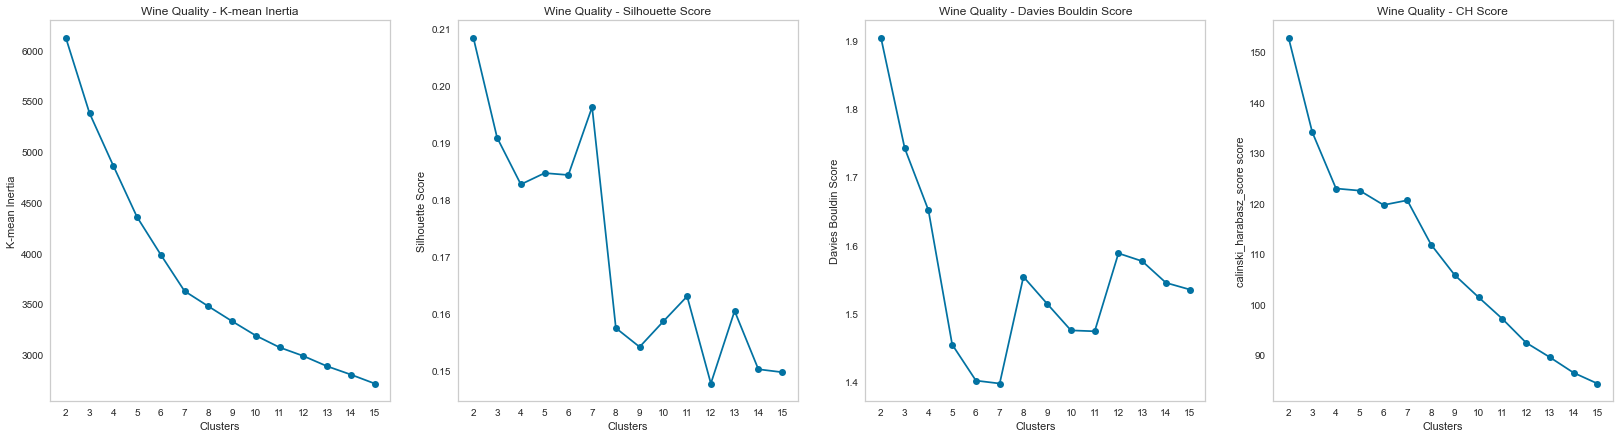

In [21]:
kmeans_k_selection_plots('Wine Quality', XW_train)

In [28]:
meanshift_cluster('Wine Quality', XW_train)

Number of estimated clusters for Wine Quality: 7


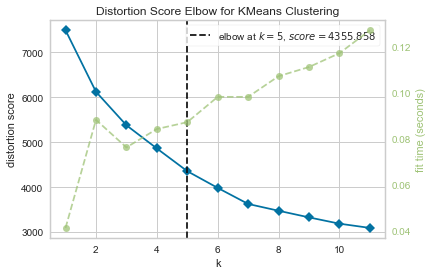

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [29]:
# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))

visualizer.fit(XW_train)        # Fit the data to the visualizer
visualizer.show()  

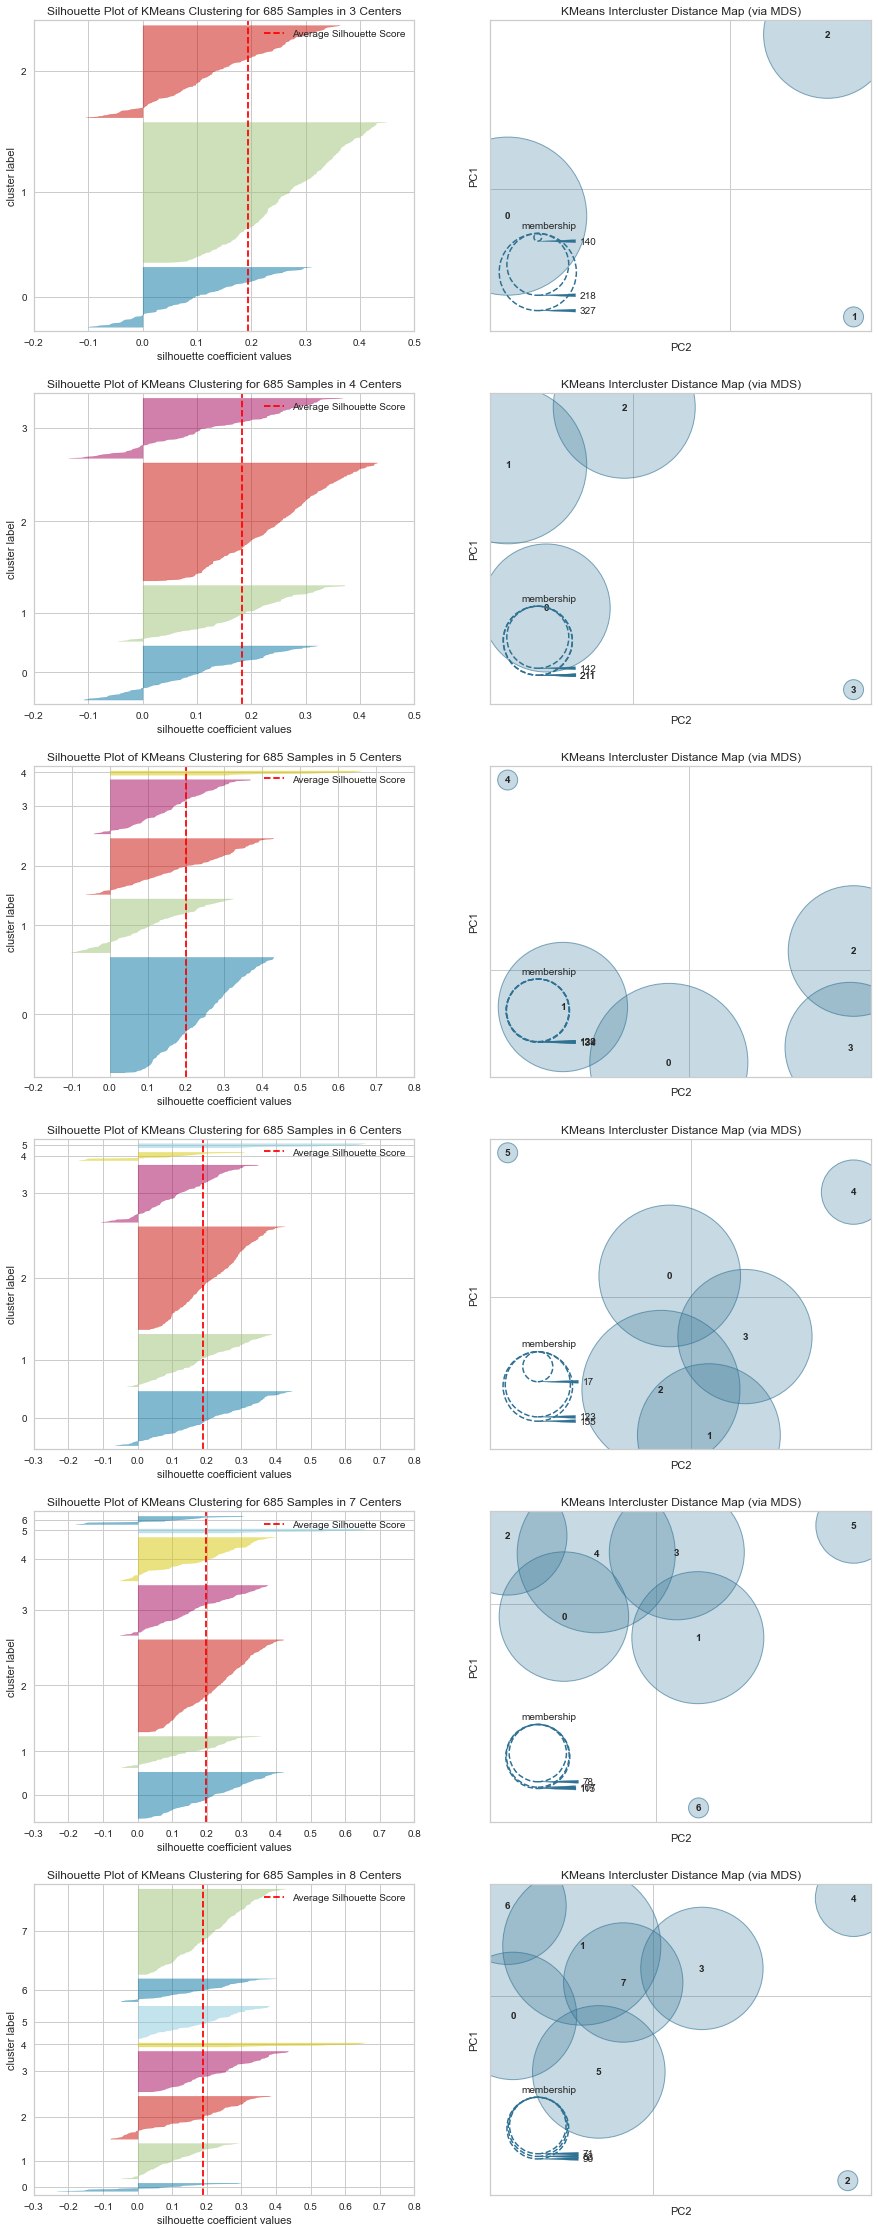

In [30]:
k = list(range(3,9))
generate_kmeans_SV_ICD_plots(XW_train, k)

<p> Clear k = 7</p>

In [22]:
# Kmeans Wine Dataset
n_clusters=7
kmeans = KMeans(
    init='k-means++',
    algorithm='auto',
    n_clusters=n_clusters,
    max_iter=1000,
    random_state=1,  # selecting random_state=1 for reproducibility
    verbose=0).fit(XW_train)

# using prediction to create a dataframe
clusters = kmeans.predict(XW_train)
cluster_df = XW_train.copy()
cluster_df['Clusters'] = clusters
cluster_df

# distribution of classes (%)
(cluster_df.Clusters.value_counts(1)*100).round(2)

2    32.85
4    18.69
1    16.35
0    16.06
3    11.39
5     3.07
6     1.61
Name: Clusters, dtype: float64

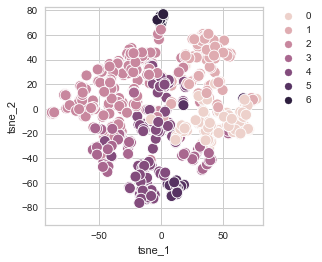

In [32]:
Tsne_plot(XW_train,clusters,5)

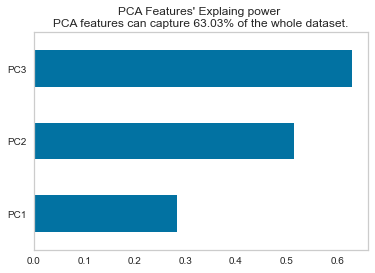

In [23]:
pca = PCA(n_components=3)
pc_feature_names = [f"PC{x}" for x in range(1, pca.n_components + 1)]
pca_data = pca.fit_transform(cluster_df)
pca_df = pd.DataFrame(pca_data, columns=pc_feature_names)
pd.Series(pca.explained_variance_ratio_.cumsum(), index=pc_feature_names).plot(
    kind='barh',
    title=
    f"""PCA Features' Explaing power \nPCA features can capture {((pca.explained_variance_ratio_.cumsum()[-1])*100).round(2)}% of the whole dataset."""
)
plt.grid()
plt.show()

pca_df['Clusters'] = clusters.astype('str')
fig = px.scatter_3d(pca_df,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color='Clusters',
                    title='Cluster visualization with the help of PCA',
                    template='plotly_dark')
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()

In [34]:
get_Dumy_classifierReport(cluster_df)

******************************************************************************************
Train accuracy score: 0.9836
Test accuracy score: 0.9197
    Possible Overfitting, diffrence of scores 6.39% crossed 5% thresh hold.
******************************************************************************************



In [35]:
# Kmeans WineDataset
km_7 = KMeans(n_clusters=7,
                    init="k-means++",
                    random_state=42).fit(XW_train)

km_7_pred = km_7.predict(XW_train)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_7_pred, yW_train.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_7_pred, yW_train.values.ravel()))
print("accuracy Score:       ", accuracy_score(km_7_pred, yW_train.values.ravel()))
print("adjusted_mutual_info Score:       ", adjusted_mutual_info_score(km_7_pred, yW_train.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(XW_train, km_7_pred))

Adjusted Rand Score:      0.07388056030669787
Homogeneity Score:        0.07996264509818557
accuracy Score:        0.11532846715328467
adjusted_mutual_info Score:        0.09438543846683878
Calinski Harabasz Score:  120.56829930625061


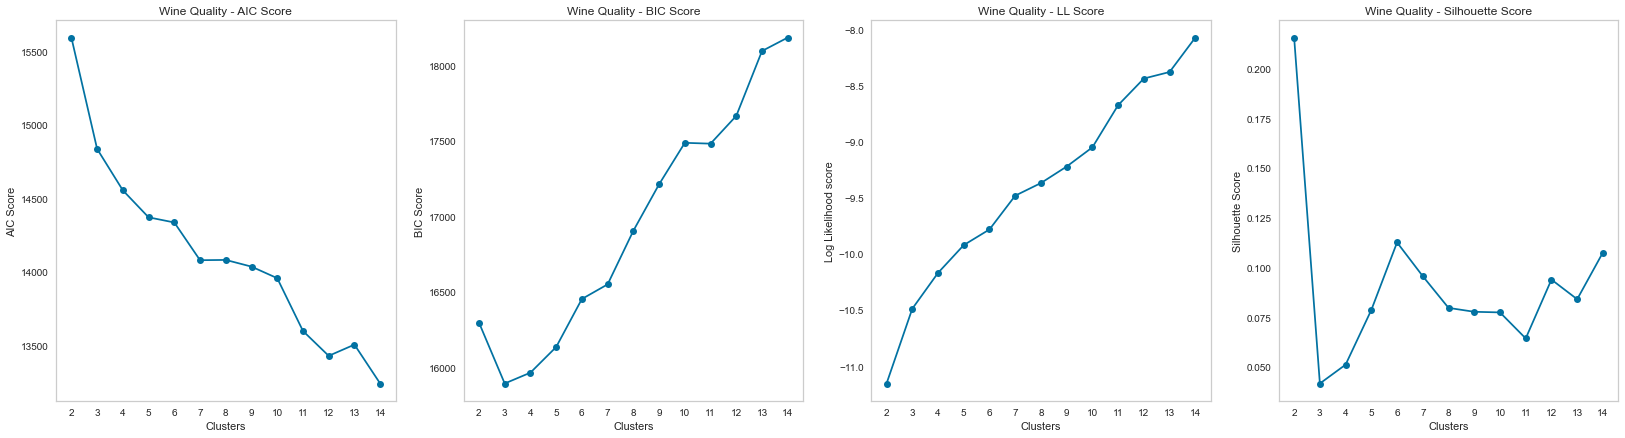

In [36]:
em_k_selection_plot('Wine Quality', XW_train)

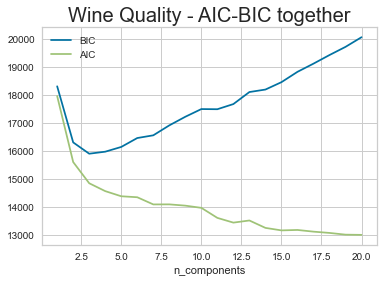

In [37]:
em_k_selection_plot_2('Wine Quality', XW_train)

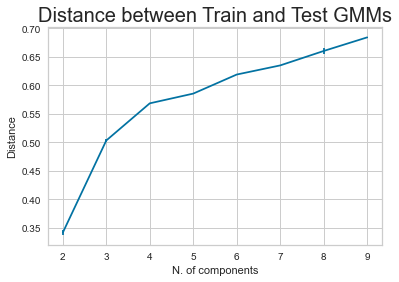

In [38]:
generate_distance_bw_gmms_plots(XW_train, 10)

<p> Clear k = 3</p>

In [40]:
# EM Wine Dataset
# setting number of cluster to 5. overfits and 3 works
n_c=6
gmm_h_pred = GaussianMixture(n_components=n_c,
                              n_init=2,
                              tol=1e-3,
                              max_iter=1000, random_state=42).fit(XW_train)
clusters = gmm_h_pred.predict(XW_train)

cluster_df = XW_train.copy()
cluster_df['Clusters'] = clusters
cluster_df

# distribution of classes (%)
(cluster_df.Clusters.value_counts(1)*100).round(2)

2    44.23
1    26.57
5    11.39
0     8.91
4     7.15
3     1.75
Name: Clusters, dtype: float64

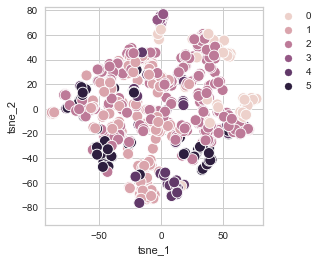

In [49]:
Tsne_plot(XW_train,clusters,5)

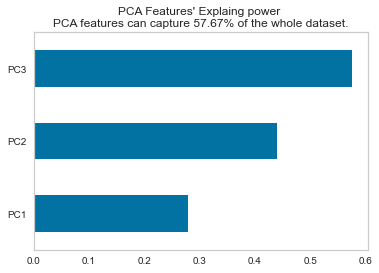

In [41]:
pca = PCA(n_components=3)
pc_feature_names = [f"PC{x}" for x in range(1, pca.n_components + 1)]
pca_data = pca.fit_transform(cluster_df)
pca_df = pd.DataFrame(pca_data, columns=pc_feature_names)
pd.Series(pca.explained_variance_ratio_.cumsum(), index=pc_feature_names).plot(
    kind='barh',
    title=
    f"""PCA Features' Explaing power \nPCA features can capture {((pca.explained_variance_ratio_.cumsum()[-1])*100).round(2)}% of the whole dataset."""
)
plt.grid()
plt.show()

pca_df['Clusters'] = clusters.astype('str')
fig = px.scatter_3d(pca_df,
                    x='PC1',
                    y='PC2',
                    z='PC3',
                    color='Clusters',
                    title='Cluster visualization with the help of PCA',
                    template='plotly_dark')
fig.update_traces(marker=dict(size=2))
fig.update_layout(width=700, height=500, bargap=0.05)
fig.show()

In [50]:
get_Dumy_classifierReport(cluster_df)

******************************************************************************************
Train accuracy score: 0.9763
Test accuracy score: 0.8029
    Possible Overfitting, diffrence of scores 17.34% crossed 5% thresh hold.
******************************************************************************************



<p>
# KMeans HeartDisease Data, k = 3 <br>
# Expected Maximization HeartDisease Data, n = 3 <br>
# KMeans Wine Quality Data, k = 7 <br>
# Expected Maximization Wine Quality Data, n = 6  <br>
</p>

In [157]:
# Kmeans HeartDataset
km_3 = KMeans(n_clusters=2,
                    init="k-means++",
                    random_state=42).fit(XH_train)

km_3_pred = km_3.predict(XH_train)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_3_pred, yH_train.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_3_pred, yH_train.values.ravel()))
print("accuracy Score:       ", accuracy_score(km_3_pred, yH_train.values.ravel()))
print("adjusted_mutual_info Score:       ", adjusted_mutual_info_score(km_3_pred, yH_train.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(XH_train, km_3_pred))

Adjusted Rand Score:      0.3275303464766054
Homogeneity Score:        0.257429782931065
accuracy Score:        0.21339563862928349
adjusted_mutual_info Score:        0.25762998877070437
Calinski Harabasz Score:  139.72218569744263


In [158]:
# EM HeartDataset
gmm_h_pred = GaussianMixture(n_components=3,
                              n_init=2,
                              tol=1e-3,
                              max_iter=1000, random_state=42).fit(heartX)
gmm_h_pred_vals = gmm_h_pred.predict(heartX)

print("Adjusted Rand Score      ", adjusted_rand_score(gmm_h_pred_vals, hearty.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(gmm_h_pred_vals, hearty.values.ravel()))
print("accuracy Score:       ", accuracy_score(gmm_h_pred_vals, hearty.values.ravel()))
print("adjusted_mutual_info Score:       ", adjusted_mutual_info_score(gmm_h_pred_vals, hearty.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(heartX, gmm_h_pred_vals))

Adjusted Rand Score       0.20176203497445314
Homogeneity Score:        0.1522108938848352
accuracy Score:        0.2374727668845316
adjusted_mutual_info Score:        0.18330247350528656
Calinski Harabasz Score:  143.49634927800008


In [161]:
# Kmeans WineDataset
km_7 = KMeans(n_clusters=7,
                    init="k-means++",
                    random_state=42).fit(XW_train)

km_7_pred = km_7.predict(XW_train)
print("Adjusted Rand Score:     ", adjusted_rand_score(km_7_pred, yW_train.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(km_7_pred, yW_train.values.ravel()))
print("accuracy Score:       ", accuracy_score(km_7_pred, yW_train.values.ravel()))
print("adjusted_mutual_info Score:       ", adjusted_mutual_info_score(km_7_pred, yW_train.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(XW_train, km_7_pred))

Adjusted Rand Score:      0.07388056030669787
Homogeneity Score:        0.07996264509818557
accuracy Score:        0.11532846715328467
adjusted_mutual_info Score:        0.09438543846683878
Calinski Harabasz Score:  120.56829930625061


In [160]:
# EM WineDataset
gmm_w_pred = GaussianMixture(n_components=6,
                              n_init=2,
                              tol=1e-3,
                              max_iter=1000, random_state=42).fit(XW_train)
gmm_w_pred_vals = gmm_w_pred.predict(XW_train)

print("Adjusted Rand Score      ", adjusted_rand_score(gmm_w_pred_vals, yW_train.values.ravel()))
print("Homogeneity Score:       ", homogeneity_score(gmm_w_pred_vals, yW_train.values.ravel()))
print("accuracy Score:       ", accuracy_score(gmm_w_pred_vals, yW_train.values.ravel()))
print("adjusted_mutual_info Score:       ", adjusted_mutual_info_score(gmm_w_pred_vals, yW_train.values.ravel()))
print("Calinski Harabasz Score: ", calinski_harabasz_score(XW_train, gmm_w_pred_vals))

Adjusted Rand Score       0.045509175930022294
Homogeneity Score:        0.06716054522581552
accuracy Score:        0.18248175182481752
adjusted_mutual_info Score:        0.07339864879007865
Calinski Harabasz Score:  57.58776004799862


### 